In [1]:
import os, sys
import io
import requests
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import skimage as ski
import cv2
import torch
import piq
import nvidia_smi

# local library of functions to connect to image server
import libutils.use_server as server

# Notebook to explore ideas for image metrics

In [2]:
img_path = server.init() 

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [3]:
files = server.get_list(img_path)
print("nombre de fichiers disponibles", len(files))
dirnames = []
for i in range(len(files)):
    dirnames.append(files[i].split('/')[4])
    
listdir = set(dirnames)
realdir = []
photo_not_in_dir = []
for ldir in listdir:
    if '.jpg' in ldir:
        photo_not_in_dir.append(ldir)
    else:
        realdir.append(ldir)

Status Code 200
nombre de fichiers disponibles 2268


In [4]:
files[0]

'/data/andra/calci_photos/REP2104/Photos/GTR2004-12_0017_REP2104_0065_0161.jpg'

In [5]:
sortedlist = sorted(realdir)

### The variance of the Laplacian can be a measure of the sharpness of the image, or the focus

In [6]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

### Magnitude of the gradient to get sharpness of edges

In [7]:
def gradient_magnitude(image):
    #Get magnitude of gradient for given image
    ddepth = cv2.CV_64F
    dx = cv2.Sobel(image, ddepth, 1, 0)
    dy = cv2.Sobel(image, ddepth, 0, 1)
    mag = cv2.magnitude(dx, dy)
    return mag

## Colour analysis
https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74

* First, we are using k-Means to cluster the top colors. Inside the function we are passing the value of how many clusters do we want to divide. Here is the documentation for K-Means clustering. After clustering we predict the colors that weigh the most — meaning getting the most area on the image.
* Secondly, we are calling the Counter function. Counter creates a container to the elements as dictionary keys, and their volume is store as dictionary values. If you are not familiar with dictionaries, they store data in key: value pairs. They are like function, and when you pass in the “key,” you can “value” as a return. Then we are ordering the colors according to the keys.

In [13]:
def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

def color_analysis(img):
    clf = KMeans(n_clusters = 5)  # 5 top colours
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i] for i in counts.keys()]
    return ordered_colors

### Function to read a directory and return some metrics

Bundle the metric calculation into one function. Add some Facebook metrics too: `piq` PyTorch Image Quality
* https://github.com/photosynthesis-team/piq/blob/master/examples/image_metrics.py

In [21]:
def read_directory(dirname, allfiles, quiet=True):
    """
    Function to read all images in a directory and return a data frame with image metrics
    
    parameters
    ----------
    dirname
        Name of directory to be read
    allfiles
        List of all files in the image server
        
    returns
    -------
    df
        Pandas dataframe of image metrics
    
    """
    ImageId = []
    Path = []
    FileName = []
    DrillName = []
    Cote0 = []
    Cote1 = []
    PxSize = []
    PySize = []
    Focus = []
    GradientMax = []
    GradientSTD = []
    Colour1 = []
    Colour2 = []
    Colour3 = []
    Colour4 = []
    Colour5 = []
    BRISQUE_i = []
    BRISQUE_l = []

    for file in allfiles:
        if dirname in file:
            img = server.get_file(file, quiet)
            #if img.size() > 89478485:
            #    continue
            l0 = file.split('/')[-1]
            l1 = l0.split('.')[0]
            l2 = l1.split('_')
            if len(l2)<3:
                continue
            width, height = img.size
            if width*height > 89478485:
                print(f'Not enough memory to process image {file} with PyTorch on local ')
            ImageId.append(0)
            Path.append(file)
            FileName.append(l0)
            DrillName.append(l2[-3])
            Cote0.append(l2[-2])
            Cote1.append(l2[-1])
            PxSize.append(width)
            PySize.append(height)

            # focus metric
            gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
            Focus.append(variance_of_laplacian(gray))
            
            # Gradient metric
            GradientMax.append(np.max(gradient_magnitude(gray)[:]))
            GradientSTD.append(np.std(gradient_magnitude(gray)[:]))
            
            # Top five colours
            colours = color_analysis(prep_image(np.asarray(img)))
            Colour1.append(colours[0])
            Colour2.append(colours[1])
            Colour3.append(colours[2])
            Colour4.append(colours[3])
            Colour5.append(colours[4])
            
            # pytorch image quality, use try, except loop to kep going if image is too large or does not conform
            try:
                x = torch.tensor(np.asarray(img)).permute(2, 0, 1)[None, ...] / 255.
                if torch.cuda.is_available():
                    # Move to GPU to make computaions faster
                    # print(torch.cuda.is_available())
                    x = x.cuda()
                brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')
                brisque_loss: torch.Tensor = piq.BRISQUELoss(data_range=1., reduction='none')(x)

                BRISQUE_i.append(brisque_index.item())
                BRISQUE_l.append(brisque_loss.item())
            except:
                print(f'Error in PyTorch with image {file}')
                BRISQUE_i.append(np.nan)
                BRISQUE_l.append(np.nan)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            del x


    d = {'ImageId':ImageId, 'Path':Path, 'FileName':FileName, 'DrillName':DrillName,
         'Cote0':Cote0, 'Cote1':Cote1, 'PxSize':PxSize, 'PySize':PySize, 'Focus':Focus,
         'Gradient max':GradientMax, 'Gradient std':GradientSTD, 'Colour1':Colour1, 'Colour2':Colour2, 'Colour3':Colour3, 
         'Colour4':Colour4, 'Colour5':Colour5, 'BRISQUE index':BRISQUE_i, 'BRISQUE loss':BRISQUE_l}
    df = pd.DataFrame(data=d)
    
    return df

In [23]:
df = read_directory(sortedlist[4], files)
df.sort_values('Cote0')

,ImageId,Path,FileName,DrillName,Cote0,Cote1,PxSize,PySize,Focus,Gradient max,Gradient std,Colour1,Colour2,Colour3,Colour4,Colour5,BRISQUE index,BRISQUE loss
4,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0000_0107.jpg,DCN2003,0000,0107,3060,602,78.144493,758.000000,48.242948,"[110.02637751466719, 96.55363161139135, 81.436...","[135.89683906328412, 129.28690158671645, 125.9...","[186.0554484295354, 148.09304252189025, 105.24...","[208.3913292530001, 208.4427102950063, 208.079...","[46.855579738232976, 47.49288929966443, 49.731...",24.443542,24.443542
8,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0077_0177.jpg,DCN2003,0077,0177,3162,612,96.133382,695.151782,53.147838,"[60.30675807282665, 55.01426470867668, 55.7572...","[149.92753023551666, 110.09798429874027, 74.39...","[103.38432363185362, 103.26420675359623, 104.5...","[159.5486890129353, 155.5443682572058, 152.836...","[203.91780938916426, 202.8382189661993, 202.02...",26.394714,26.394714
3,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0167_0287.jpg,DCN2003,0167,0287,3456,618,73.054004,915.004918,46.040015,"[127.71767279347029, 91.77297551235964, 55.176...","[57.16299444563464, 51.7510356890852, 47.72783...","[95.5396335947433, 96.5672752444382, 98.410392...","[146.34709040777523, 140.13262516325682, 135.8...","[186.38492936222997, 186.73471688972234, 191.2...",28.965027,28.965027
9,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0258_0328.jpg,DCN2003,0258,0328,2190,627,100.182191,867.129748,54.151295,"[85.44629607645196, 77.35695524426, 65.1145530...","[111.22259911752714, 106.97283148684181, 102.3...","[27.221625280252795, 27.639536359410258, 26.56...","[135.64956387890945, 137.94833889173924, 142.1...","[172.49530402355137, 174.63208735411456, 182.2...",28.151062,28.151062
0,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0303_0402.jpg,DCN2003,0303,0402,2982,618,55.254845,855.000585,42.898129,"[103.58520132067054, 109.26092138200887, 115.0...","[67.43420293376855, 61.92184225710703, 58.0277...","[137.93672422688036, 107.31695547934476, 70.30...","[147.6118315526176, 143.51596299015017, 142.02...","[181.4181003526037, 184.74272819272443, 194.49...",29.930359,29.930359
11,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0370_0411.jpg,DCN2003,0370,0411,1662,606,141.545177,767.262667,64.398602,"[177.26322612814346, 173.0802418349581, 160.05...","[109.21023468546284, 101.30282672266415, 87.27...","[37.87514291346508, 39.733727577378176, 40.567...","[146.29507890007187, 133.19812904655106, 117.7...","[217.73240759650918, 218.1965693281238, 214.60...",28.382507,28.382507
2,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0408_0489.jpg,DCN2003,0408,0489,2772,609,107.585757,702.522598,57.953451,"[147.46576298633326, 109.23746038836049, 71.73...","[105.42815151715332, 108.02380534773579, 110.3...","[63.238029636093344, 56.04840227142725, 50.332...","[155.32619912557078, 148.15753391628783, 142.3...","[201.81331877729528, 200.29139234124824, 203.1...",24.942566,24.942566
14,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0467_0587.jpg,DCN2003,0467,0587,3456,618,96.223486,961.004683,50.762406,"[63.814659192623566, 57.08999952894396, 51.686...","[147.8802748337994, 108.1239255612127, 73.2246...","[107.36367774952728, 107.65793852626224, 111.6...","[150.258423410794, 146.69021266190364, 145.839...","[194.10643310369016, 192.74606830987716, 194.8...",27.923523,27.923523
13,0,/data/andra/calci_photos/DCN2003/Photos/GTR201...,GTR2014-10_0026_DCN2003_0560_0640.jpg,DCN2003,0560,0640,2505,639,74.395390,868.020737,46.217278,"[84.37768662668498, 70.28038283459526, 57.8540...","[112.48927094875748, 100.26049969618288, 93.65...","[31.261304452796864, 28.88169558169504, 28.141...","[132.12452576478134, 130.9857026227912, 133.13...","[174.14411796789477, 171.160143195696

Status Code 200


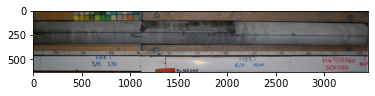

In [24]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

Status Code 200


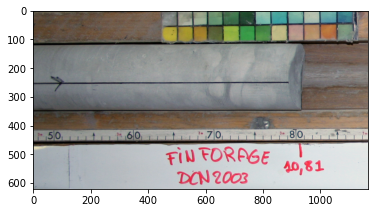

In [25]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()

### Plot by colour RGB

In [31]:
colours = df['Colour1'].values
red = np.zeros((len(colours),))
green = np.zeros((len(colours),))
blue = np.zeros((len(colours),))
for i,colour in enumerate(colours):
    red[i] = colour[0]
    green[i] = colour[1]
    blue[i] = colour[2]

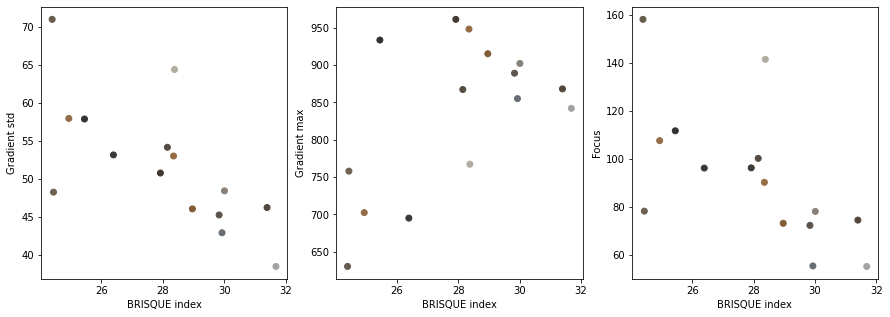

In [44]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.scatter(df['BRISQUE index'], df['Gradient std'], c=df['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient std')
plt.subplot(1,3,2)
plt.scatter(df['BRISQUE index'], df['Gradient max'], c=df['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient max')
plt.subplot(1,3,3)
plt.scatter(df['BRISQUE index'], df['Focus'], c=df['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Focus')
plt.show()

## Find the worst and best image by Focus and BRISQUE

In [ ]:
del df
if os.path.isfile('./BRISQUE_data.pkl') == False:
    for i, directory in enumerate(sortedlist):

        print(f'Going into {directory}, i={i}')
        if i == 0:
            df = read_directory(directory, files)
        else:
            _df = read_directory(directory, files)
            df = pd.concat([df, _df])


        nvidia_smi.nvmlInit()
        handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
        # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate
        info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
        print("Free memory:", info.free)
        nvidia_smi.nvmlShutdown()

    df.to_pickle('./BRISQUE_data.pkl')
else:
    df = pd.read_pickle('./BRISQUE_data.pkl')
df = df.reset_index(drop=True)

Going into BPE4023, i=0
Free memory: 2824601600
Going into BPE4024, i=1
Free memory: 2820210688
Going into DCN2001, i=2
Free memory: 2812936192
Going into DCN2002, i=3
Free memory: 2812936192
Going into DCN2003, i=4
Free memory: 2811297792
Going into DIR1001, i=5
Free memory: 2726690816
Going into DIR1002, i=6
Free memory: 2727936000
Going into DIR1003, i=7
Free memory: 2726100992
Going into DIR2001, i=8
Free memory: 2797862912
Going into DIR2002, i=9
Free memory: 2799042560
Going into DIR2003, i=10
Free memory: 2797469696
Going into DPC3015, i=11
Free memory: 2803171328
Going into DPC3022, i=12
Free memory: 2801664000
Going into DPC3024, i=13
Free memory: 2801270784
Going into FOR1001, i=14
Free memory: 2803236864
Going into FOR1002, i=15


In [ ]:
df

In [ ]:
plt.figure(figsize=[10,10])
#ax = df.plot.scatter(x='BRISQUE index', y='Focus', c='DarkBlue')
ax = sns.scatterplot(data=df, x='BRISQUE index', y='Focus', hue='DrillName')
plt.legend([],[], frameon=False)
plt.show()

In [ ]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmax()])
plt.imshow(img)
plt.show()

In [ ]:
img = server.get_file(df['Path'][df['BRISQUE index'].idxmin()])
plt.imshow(img)
plt.show()

In [ ]:
img = server.get_file(df['Path'][df['Focus'].idxmax()])
plt.imshow(img)
plt.show()

In [ ]:
img = server.get_file(df['Path'][df['Focus'].idxmin()])
plt.imshow(img)
plt.show()

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.scatter(df['BRISQUE index'], df['Gradient std'], c=df['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient std')
plt.subplot(1,3,2)
plt.scatter(df['BRISQUE index'], df['Gradient max'], c=df['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Gradient max')
plt.subplot(1,3,3)
plt.scatter(df['BRISQUE index'], df['Focus'], c=df['Colour1']/255)
plt.xlabel('BRISQUE index')
plt.ylabel('Focus')
plt.show()